In [1]:
import wandb
from pathlib import Path
import torch
import numpy as np
from plotting import *

In [ ]:
run = wandb.init(mode="disabled") #job_type="download",

In [ ]:
artifact = run.use_artifact('jet-tagging/Particle-Physics/charged_seed-2_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v1', type='results')
artifact_dir = artifact.download()

artifact_dir = next(iter(Path(artifact_dir).iterdir()))
results = torch.load(artifact_dir, map_location=torch.device('cpu')) #, weight_only=False
results

In [2]:
wandb.init(mode="disabled")

# Use read-only API
api = wandb.Api()


In [ ]:
# Get the artifact directly by full name
artifact = api.artifact(
    'jet-tagging/Particle-Physics/charged_seed-2_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v1',
    type='results'
)

# Download the artifact
artifact_dir = artifact.download()

# Get the first file/subdir inside the artifact directory
artifact_dir = next(iter(Path(artifact_dir).iterdir()))

# Load the torch object
results = torch.load(artifact_dir, map_location=torch.device('cpu'))
results

In [73]:
torch.mean((results["energies"]) ** 2, dim=(0, 2)).shape

torch.Size([10])

Data(targets=[T, traj_len, N, 3],preds=[T, traj_len, N, 3],energy_conservation=[T, traj_len, 1], test_loss=FLOAT)

In [19]:
results['preds'].nonzero().shape, results['targets'].nonzero().shape

(torch.Size([2400000, 4]), torch.Size([2400000, 4]))

In [64]:
results['energy_conservation'].shape, results['energy_conservation'].mean(), results['energy_conservation'].std()

(torch.Size([2000, 20, 1]), tensor(-3.3102), tensor(15.7346))

### Parameters configuration

In [3]:
datasets = ['charged', 'gravity']
models = {
    'EGNO': 'v0',
    'SEGNO': 'v1'
}
n_balls_values = [5, 10, 20]
num_inputs_values = [1, 2, 3]
num_timesteps_values = [10]
seeds = [1, 2, 3]
varDT_values = [False, True]
colors = {'EGNO': 'purple', 'SEGNO': 'green'}
models.items()

dict_items([('EGNO', 'v0'), ('SEGNO', 'v1')])

In [ ]:
#configuration = f'{dataset}_seed-{seed}_n_part-{n_balls}_n_inputs-{n_inputs}_varDT-{varDT}_num_timesteps-{num_timestep}:{models[model]}'

### Plotting

In [36]:
from plotting import *
import itertools

In [ ]:
run = wandb.init()

print(f"Running with: dataset={dataset}, model={model_name}, version={model_version}, "
          f"n_balls={n_balls}, num_inputs={num_inputs}, num_timesteps={num_timesteps}, "
          f"seed={seed}, varDT={varDT}")

In [ ]:
# Generate all combinations
metric = 'MSE'
configs = []
baseline = False
for dataset, n_balls, num_inputs, varDT, num_timesteps in itertools.product(
    datasets, n_balls_values, num_inputs_values, varDT_values, num_timesteps_values):
    for model_name, model_version in models.items():
        config = {}
        data_seeds = []
        for seed in seeds:
            
            configuration = f'{dataset}_seed-{seed}_n_part-{n_balls}_n_inputs-{num_inputs}_varDT-{varDT}_num_timesteps-{num_timesteps}:{model_version}'
            
            artifact = api.artifact(f'jet-tagging/Particle-Physics/{configuration}', type='results')
            artifact_dir = artifact.download()
            artifact_dir = next(iter(Path(artifact_dir).iterdir()))
            results = torch.load(artifact_dir, map_location=torch.device('cpu')) #, weight_only=False
            #Data(targets=[T, traj_len, N, 3],preds=[T, traj_len, N, 3],energy_conservation=[T, traj_len, 1], test_loss=FLOAT)
            print(f"Results loaded for configuration: {configuration}")
            n_samples = results['preds'].shape[0]
            T = results['preds'].shape[1]
            N = results['preds'].shape[2]
            D = results['preds'].shape[3]
            preds = results['preds'].view(n_samples, T, N*D)  # Flatten the last two dimensions
            targets = results['targets'].view(n_samples, T, N*D)
            energy_conservation = results['energy_conservation'] if model_name == 'EGNO' else results['energies']

            combined = np.stack([targets, preds], axis=0)  # shape: (2, #samples, traj_len, N, 3)
            print(preds.shape, targets.shape, combined.shape)
            data_seeds.append(combined)
    
        final_data = np.stack(data_seeds, axis=0)
        print(f"Final data shape: {final_data.shape}")
        config["model"] = model_name
        config["data"] = torch.tensor(final_data)
        config["num_timesteps"] = num_timesteps
        config["color"] = colors[model_name]
        config["label"] = f'{dataset}_{model_name}_n_part-{n_balls}_n_inputs-{num_inputs}_varDT-{varDT}_num_timesteps-{num_timesteps}'
        config["baseline"] = baseline
        configs.append(config)
        
    plot_multiple_curves_wandb(configs, plot_function_wandb, metric=metric, save=True, filename=f'{dataset}_plots/n_part-{n_balls}_n_inputs-{num_inputs}_varDT-{varDT}_num_timesteps-{num_timesteps}.png', run=run)

## Testing

In [77]:
from wandb.apis.public import Run

run = Run(
    client=api.client,
    entity="jet-tagging",
    project="Particle-Physics",
    run_id= '3w20dycu', # ITERATE IDs
    include_sweeps = True,
)
model_type = run.config.get("model")
print(f"Model type: {model_type}")
for art in run.logged_artifacts():
    print(art.name, art.type, art.version, art.digest)	

Model type: segno
charged_seed-1_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v1 results v1 b7baa747a39e2a3a5fafca2cf328a75e


In [22]:
B, N, D = 4, 5, 6
array1 = np.random.randn(B, N, D)
array2 = np.random.randn(B, N, D)

# Stack along a new first axis to get shape (2, B, N, D)
combined = np.stack([array1, array2], axis=0)  # shape: (2, B, N, D)

In [23]:
combined1 = combined  # first one
combined2 = np.stack([np.random.randn(B, N, D), np.random.randn(B, N, D)], axis=0)
combined3 = np.stack([np.random.randn(B, N, D), np.random.randn(B, N, D)], axis=0)

# Stack along a new first axis to get shape (3, 2, B, N, D)
final_array = np.stack([combined1, combined2, combined3], axis=0)
final_array.shape  # shape: (3, 2, B, N, D)

(3, 2, 4, 5, 6)

In [ ]:
configs = []
dataset = 'gravity'
metric = 'MSE'
baselines = []
for model_name, model_version in models.items():
    config = {}
    data_seeds = [] 
    for seed in seeds:
        
        configuration = f'{dataset}_seed-{seed}_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:{model_version}'
        
        artifact = api.artifact(f'jet-tagging/Particle-Physics/{configuration}', type='results')
        artifact_dir = artifact.download()
        source_run = artifact.logged_by()
        model_type = source_run.config.get("model") 
        print(model_type)
        artifact_dir = next(iter(Path(artifact_dir).iterdir()))
        results = torch.load(artifact_dir, map_location=torch.device('cpu')) #, weight_only=False
        #Data(targets=[T, traj_len, N, 3],preds=[T, traj_len, N, 3],energy_conservation=[T, traj_len, 1], test_loss=FLOAT)
        print(f"Results loaded for configuration: {configuration}")
        n_samples = results['preds'].shape[0]
        T = results['preds'].shape[1]
        N = results['preds'].shape[2]
        D = results['preds'].shape[3]
        preds = results['preds'].view(n_samples, T, N*D)  # Flatten the last two dimensions
        targets = results['targets'].view(n_samples, T, N*D)
        energy_conservation = results['energy_conservation'] if model_name == 'EGNO' else results['energies']
        print(energy_conservation.shape)
        combined = np.stack([targets, preds], axis=0)  # shape: (2, #samples, traj_len, N, 3)
        print(preds.shape, targets.shape, combined.shape)
        data_seeds.append(combined)

    final_data = np.stack(data_seeds, axis=0)
    print(f"Final data shape: {final_data.shape}")
    config["model"] = model_name
    config["data"] = torch.tensor(final_data)
    config["num_timesteps"] = 10
    config["color"] = colors[model_name]
    config["label"] = f'{dataset}_{model_name}_n_part-5_n_inputs-3_varDT-False_num_timesteps-10'
    config["baseline"] = True
    configs.append(config)
    baselines.append(config)

wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v0
torch.Size([2000, 20, 1])
torch.Size([2000, 20, 15]) torch.Size([2000, 20, 15]) (2, 2000, 20, 15)


C:\Users\Matteo Celia\AppData\Local\Temp\ipykernel_36220\1116681363.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(artifact_dir, map_location=torc

egno
Results loaded for configuration: gravity_seed-2_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v0
torch.Size([2000, 20, 1])
torch.Size([2000, 20, 15]) torch.Size([2000, 20, 15]) (2, 2000, 20, 15)


wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-3_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v0
torch.Size([2000, 20, 1])
torch.Size([2000, 20, 15]) torch.Size([2000, 20, 15]) (2, 2000, 20, 15)
Final data shape: (3, 2, 2000, 20, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v1
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-2_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v1
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-3_n_part-5_n_inputs-1_varDT-False_num_timesteps-10:v1
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)
Final data shape: (3, 2, 2000, 10, 15)


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v0
torch.Size([2000, 20, 1])
torch.Size([2000, 20, 15]) torch.Size([2000, 20, 15]) (2, 2000, 20, 15)
0
Final data shape: (1, 2, 2000, 20, 15)


C:\Users\Matteo Celia\AppData\Local\Temp\ipykernel_17312\886206884.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(artifact_dir, map_location=torch

segno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v1
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)
0
Final data shape: (1, 2, 2000, 10, 15)
(1, 2, 2000, 20, 15)
torch.Size([2, 2000, 20, 15])
torch.Size([2000, 20, 15]) torch.Size([2000, 20, 15])
(1, 2, 2000, 10, 15)
torch.Size([2, 2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])


c:\Users\Matteo Celia\OneDrive\Documenti\GitHub\NO-NODE-comparison\plotting.py:422: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  std_mse = torch.std(mse_losses, dim=0)    # Shape: (T,)
c:\Users\Matteo Celia\OneDrive\Documenti\GitHub\NO-NODE-comparison\plotting.py:568: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  std_corr = torch.std(correlations, dim=0)    # Shape: (T,)


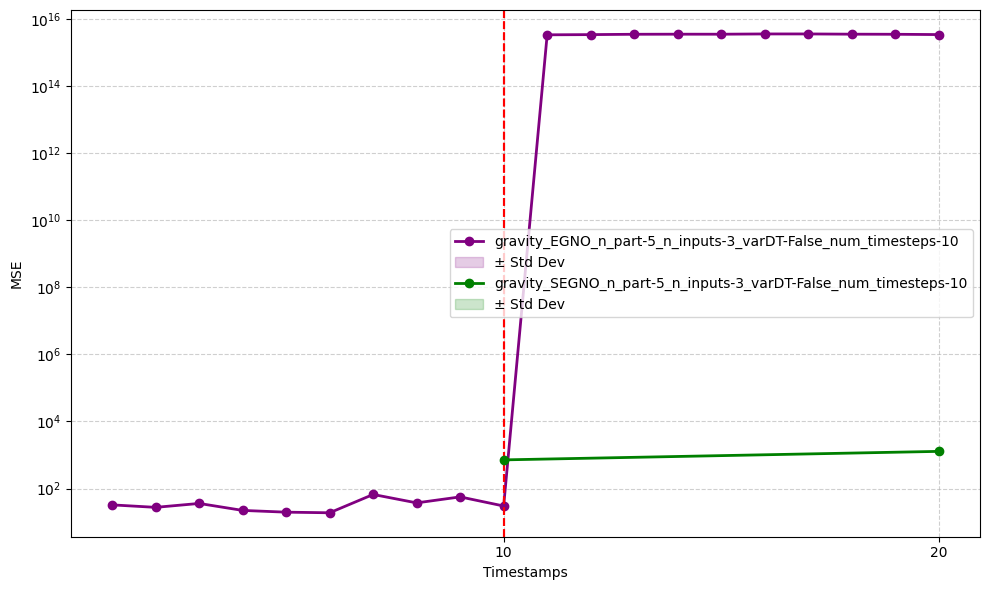

In [14]:
configs = []
dataset = 'gravity'
metric = 'MSE' #'MSE
baseline = False
for model_name, model_version in models.items():
    config = {}
    data_seeds = [] 
    energies = []
    for seed in seeds:
        
        configuration = f'{dataset}_seed-{seed}_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:{model_version}'
        
        artifact = api.artifact(f'jet-tagging/Particle-Physics/{configuration}', type='results')
        artifact_dir = artifact.download()
        source_run = artifact.logged_by()
        model_type = source_run.config.get("model") 
        print(model_type)
        artifact_dir = next(iter(Path(artifact_dir).iterdir()))
        results = torch.load(artifact_dir, map_location=torch.device('cpu')) #, weight_only=False
        #Data(targets=[T, traj_len, N, 3],preds=[T, traj_len, N, 3],energy_conservation=[T, traj_len, 1], test_loss=FLOAT)
        print(f"Results loaded for configuration: {configuration}")
        n_samples = results['preds'].shape[0]
        T = results['preds'].shape[1]
        N = results['preds'].shape[2]
        D = results['preds'].shape[3]
        preds = results['preds'].view(n_samples, T, N*D)  # Flatten the last two dimensions
        targets = results['targets'].view(n_samples, T, N*D)
        energy_conservation = results['energy_conservation'] if model_name == 'EGNO' else results['energies']
        print(energy_conservation.shape)
        energies.append(energy_conservation)
        combined = np.stack([targets, preds], axis=0)  # shape: (2, #samples, traj_len, N, 3)
        print(preds.shape, targets.shape, combined.shape)
        data_seeds.append(combined)

    final_data = np.stack(data_seeds, axis=0)
    energies = np.stack(energies, axis=0)
    print(np.size(final_data) - np.count_nonzero(final_data))
    print(f"Final data shape: {final_data.shape}")
    config["model"] = model_name
    config["data"] = torch.tensor(final_data)
    config["energy"] = torch.tensor(energies)
    config["num_timesteps"] = 10
    config["color"] = colors[model_name]
    config["label"] = f'{dataset}_{model_name}_n_part-5_n_inputs-3_varDT-False_num_timesteps-10'
    config["baseline"] = baseline
    config["dataset"] = dataset
    configs.append(config)

#out the cycle, call plotting functions
if baseline:
    configs.extend(baselines)
plot_multiple_curves_wandb(configs, plot_function_wandb, metric=metric, save=False, filename=f'{dataset}_plots/n_part-5_n_inputs-3_varDT-False_num_timesteps-10.png')

## load artifact name from json

In [10]:
import json

def load_artifact():
    # Load JSON file into a Python dict
    with open("artifact_model_map_complete.json", "r") as f:
        data = json.load(f)
    return data

In [ ]:
data = load_artifact()
exp_data = data["charged_n_part-20_n_inputs-1_varDT-False_num_timesteps-10"]
# "charged_n_part-20_n_inputs-1_varDT-False_num_timesteps-10": {
#     "segno": {
#       "2": "charged_seed-2_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v1",
#       "3": "charged_seed-3_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v1"
#     },
#     "egno": {
#       "3": "charged_seed-3_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v0",
#       "2": "charged_seed-2_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v0",
#       "1": "charged_seed-1_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v0"
#     }
configs = []
dataset = 'gravity'
metric = 'MSE'
baseline = False
for model_name, model_version in models.items():
    config = {}
    data_seeds = [] 
    energies = []
    for seed in seeds:
        
        configuration = f'{exp_data[model_name.lower()][str(seed)]}'
        
        artifact = api.artifact(f'jet-tagging/Particle-Physics/{configuration}', type='results')
        artifact_dir = artifact.download()
        source_run = artifact.logged_by()
        model_type = source_run.config.get("model") 
        print(model_type)
        artifact_dir = next(iter(Path(artifact_dir).iterdir()))
        results = torch.load(artifact_dir, map_location=torch.device('cpu')) #, weight_only=False
        #Data(targets=[T, traj_len, N, 3],preds=[T, traj_len, N, 3],energy_conservation=[T, traj_len, 1], test_loss=FLOAT)
        print(f"Results loaded for configuration: {configuration}")
        n_samples = results['preds'].shape[0]
        T = results['preds'].shape[1]
        N = results['preds'].shape[2]
        D = results['preds'].shape[3]
        preds = results['preds'].view(n_samples, T, N*D)  # Flatten the last two dimensions
        targets = results['targets'].view(n_samples, T, N*D)
        energy_conservation = results['energy_conservation'] if model_name == 'EGNO' else results['energies']
        print(energy_conservation.shape)
        energies.append(energy_conservation)
        combined = np.stack([targets, preds], axis=0)  # shape: (2, #samples, traj_len, N, 3)
        print(preds.shape, targets.shape, combined.shape)
        data_seeds.append(combined)

    final_data = np.stack(data_seeds, axis=0)
    print(np.size(final_data) - np.count_nonzero(final_data))
    print(f"Final data shape: {final_data.shape}")
    config["model"] = model_name
    config["data"] = torch.tensor(final_data)
    config["energy"] = torch.tensor(energies)
    config["num_timesteps"] = 10
    config["color"] = colors[model_name]
    config["label"] = f'{dataset}_{model_name}_n_part-5_n_inputs-3_varDT-False_num_timesteps-10'
    config["baseline"] = True
    configs.append(config)

#out the cycle, call plotting functions
if baseline:
    configs.extend(baselines)
plot_multiple_curves_wandb(configs, plot_function_wandb, metric=metric, save=False, filename=f'{dataset}_plots/n_part-5_n_inputs-3_varDT-False_num_timesteps-10.png')

## Table generation

In [10]:
from plotting import *
headers = ["model", "avgMSE", "avgMAE","MSE first step", "MAE first step", "avgED"]
dataset = 'gravity'
metric = 'MSE'
data = []
varDT = True
std = False
n_parts = 5
# seeds = [1]
num_inputs_values = [2,3]
for num_inputs in num_inputs_values:
    for model_name, model_version in models.items():
        config = {}
        data_seeds = [] 
        energies = []
        for seed in seeds:
            
            configuration = f'{dataset}_seed-{seed}_n_part-{n_parts}_n_inputs-{num_inputs}_varDT-False_num_timesteps-10:{model_version}'
            
            artifact = api.artifact(f'jet-tagging/Particle-Physics/{configuration}', type='results')
            artifact_dir = artifact.download()
            source_run = artifact.logged_by()
            model_type = source_run.config.get("model") 
            print(model_type)
            artifact_dir = next(iter(Path(artifact_dir).iterdir()))
            results = torch.load(artifact_dir, map_location=torch.device('cpu')) #, weight_only=False
            #Data(targets=[T, traj_len, N, 3],preds=[T, traj_len, N, 3],energy_conservation=[T, traj_len, 1], test_loss=FLOAT)
            print(f"Results loaded for configuration: {configuration}, {results}")
            n_samples = results['preds'].shape[0]
            T = results['preds'].shape[1]
            N = results['preds'].shape[2]
            D = results['preds'].shape[3]
            preds = results['preds'].view(n_samples, T, N*D)  # Flatten the last two dimensions
            targets = results['targets'].view(n_samples, T, N*D)
            energy_conservation = results['energy_conservation'] if model_name == 'EGNO' and results['energy_conservation'] is not None else results['energies']
            if dataset == 'gravity':
                preds = preds[:, :10, :]
                targets = targets[:, :10, :]
                energy_conservation = energy_conservation[:, :10, :]
            print(energy_conservation.shape)
            energies.append(energy_conservation)
            combined = np.stack([targets, preds], axis=0)  # shape: (2, #samples, traj_len, N, 3)
            print(preds.shape, targets.shape, combined.shape)
            data_seeds.append(combined)

        final_data = np.stack(data_seeds, axis=0)
        energies = np.stack(energies, axis=0)
        print(np.size(final_data) - np.count_nonzero(final_data))
        print(f"Final data shape: {final_data.shape}")
        config["model"] = model_name
        config["data"] = torch.tensor(final_data)
        config["energy"] = torch.tensor(energies)
        config["num_timesteps"] = 10
        config["dataset"] = dataset
        config["color"] = colors[model_name]
        config["label"] = f'{dataset}_{model_name}_n_part-5_n_inputs-3_varDT-False_num_timesteps-10'
        if std:
            index, avg_mse, avg_std_mse, avg_mae, avg_std_mae, first_mse, first_mae, avg_ed, avg_std_ed = compute_avg_loss_until_t_wandb(config=config, std=std)
        else:
            index, avg_mse, avg_mae, first_mse, first_mae, avg_ed = compute_avg_loss_until_t_wandb(config=config, std=std)

        vdt = 'VDT' if varDT else ''
        mi = f'_MI({num_inputs})' if num_inputs > 1 else ''
        model_label = f'{model_name}{mi}{vdt}'
        index        = np.nan_to_num(index, nan=0)
        avg_mse      = np.nan_to_num(avg_mse, nan=0)
        # avg_std_mse  = np.nan_to_num(avg_std_mse, nan=0)
        avg_mae      = np.nan_to_num(avg_mae, nan=0)
        # avg_std_mae  = np.nan_to_num(avg_std_mae, nan=0)
        first_mse    = np.nan_to_num(first_mse, nan=0)
        first_mae    = np.nan_to_num(first_mae, nan=0)
        avg_ed       = np.nan_to_num(avg_ed, nan=0)
        # avg_std_ed   = np.nan_to_num(avg_std_ed, nan=0)
        data.append([model_label,round(avg_mse.item(), 4), round(avg_mae.item(), 4),  round(first_mse.item(), 4),round(first_mae.item(), 4), round(avg_ed.item(), 4)])
#out the cycle, call plotting functions
print_latex_table(headers, data)

wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-2_varDT-False_num_timesteps-10:v0, Data(targets=[2000, 20, 5, 3], preds=[2000, 20, 5, 3], energy_conservation=[2000, 20, 1], test_loss=60758242038.62889)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


C:\Users\Matteo Celia\AppData\Local\Temp\ipykernel_37156\2918031179.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(artifact_dir, map_location=torc

egno
Results loaded for configuration: gravity_seed-2_n_part-5_n_inputs-2_varDT-False_num_timesteps-10:v0, Data(targets=[2000, 20, 5, 3], preds=[2000, 20, 5, 3], energy_conservation=[2000, 20, 1], test_loss=2.9100493144947174e+17)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-3_n_part-5_n_inputs-2_varDT-False_num_timesteps-10:v0, Data(targets=[2000, 20, 5, 3], preds=[2000, 20, 5, 3], energy_conservation=[2000, 20, 1], test_loss=4.557147877746583e+19)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)
0
Final data shape: (3, 2, 2000, 10, 15)
t_last, first -1 9
(3, 2, 2000, 10, 15)
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
(3, 2000, 10, 1)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-2_varDT-False_num_timesteps-10:v1, Data(targets=[2000, 10, 5, 3], preds=[2000, 10, 5, 3], energies=[2000, 10, 1], test_loss=7920.25180859375, traj_losses=[16])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-2_n_part-5_n_inputs-2_varDT-False_num_timesteps-10:v1, Data(targets=[2000, 10, 5, 3], preds=[2000, 10, 5, 3], energies=[2000, 10, 1], test_loss=7560.27077734375, traj_losses=[16])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-3_n_part-5_n_inputs-2_varDT-False_num_timesteps-10:v1, Data(targets=[2000, 10, 5, 3], preds=[2000, 10, 5, 3], energies=[2000, 10, 1], test_loss=8260.992375, traj_losses=[16])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)
0
Final data shape: (3, 2, 2000, 10, 15)
t_last, first 2 0
(3, 2, 2000, 10, 15)
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
(3, 2000, 10, 1)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])


wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v0, Data(targets=[2000, 20, 5, 3], preds=[2000, 20, 5, 3], energy_conservation=[2000, 20, 1], test_loss=1740476982024198.8)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-2_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v0, Data(targets=[2000, 20, 5, 3], preds=[2000, 20, 5, 3], energy_conservation=[2000, 20, 1], test_loss=3.9347694213676845e+22)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


egno
Results loaded for configuration: gravity_seed-3_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v0, Data(targets=[2000, 20, 5, 3], preds=[2000, 20, 5, 3], energy_conservation=[2000, 20, 1], test_loss=inf)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)
0
Final data shape: (3, 2, 2000, 10, 15)
t_last, first -1 9
(3, 2, 2000, 10, 15)
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
(3, 2000, 10, 1)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-1_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v1, Data(targets=[2000, 10, 5, 3], preds=[2000, 10, 5, 3], energies=[2000, 10, 1], test_loss=8549.40455859375, traj_losses=[16])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-2_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v1, Data(targets=[2000, 10, 5, 3], preds=[2000, 10, 5, 3], energies=[2000, 10, 1], test_loss=8429.4992421875, traj_losses=[16])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)


wandb:   1 of 1 files downloaded.  


segno
Results loaded for configuration: gravity_seed-3_n_part-5_n_inputs-3_varDT-False_num_timesteps-10:v1, Data(targets=[2000, 10, 5, 3], preds=[2000, 10, 5, 3], energies=[2000, 10, 1], test_loss=8824.988265625, traj_losses=[16])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15]) (2, 2000, 10, 15)
0
Final data shape: (3, 2, 2000, 10, 15)
t_last, first 2 0
(3, 2, 2000, 10, 15)
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2, 2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
torch.Size([2000, 10, 15]) torch.Size([2000, 10, 15])
(3, 2000, 10, 1)
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])
torch.Size([2000, 10, 1])
\begin{tabular}{lrrrrr}
\hline
 model          &    avgMSE &   avgMAE &   MSE first step &   MAE first step &    avgED \\
\hline
 EGNO\_MI(2)VDT  &   715.454 &   2.4506 &          322.052 &           2.2757 &  7768.68 \\
 SEGNO\_MI(2)VDT &   56

### random testing


In [10]:
model_type = run.config.get("model")
print(model_type)

egno


In [11]:
(t_last, first) = (-1, 3) if False else (2 if False else 5, 0)
print(f"t_last: {t_last}, first: {first}")

t_last: 5, first: 0


In [12]:
np.size(final_data) - np.count_nonzero(final_data)  # Count non-zero elements in the first sample of the first seed

NameError: name 'np' is not defined

In [ ]:
label = f'{dataset}_{model_name}_n_part-{n_balls}_n_inputs-{num_inputs}_varDT-{varDT}_num_timesteps-{num_timesteps}'

In [ ]:
B, N, D = 2, 3, 4
x = np.random.randn(B, N, D)
print(x.shape)         # (2, 3, 4)
x_flat = x.reshape(B, N * D)
print(x_flat.shape)    # (2, 12)
print(x,x_flat)

(2, 3, 4)
(2, 12)
[[[-0.13883326 -0.86092433 -0.46132982  0.00884938]
  [-1.41886847  0.4353888   0.27006243  0.44236889]
  [ 0.87912302 -1.12081852  1.36392799 -0.37009039]]

 [[ 1.48128083 -0.21777604  1.49859309  0.17732918]
  [ 0.03388336 -0.15623612  1.0724678   1.29727964]
  [ 0.56262496  1.69323735 -0.83003566  0.54243966]]] [[-0.13883326 -0.86092433 -0.46132982  0.00884938 -1.41886847  0.4353888
   0.27006243  0.44236889  0.87912302 -1.12081852  1.36392799 -0.37009039]
 [ 1.48128083 -0.21777604  1.49859309  0.17732918  0.03388336 -0.15623612
   1.0724678   1.29727964  0.56262496  1.69323735 -0.83003566  0.54243966]]


## Generate artifacts map from csv

In [9]:
import csv
import re
from wandb.apis.public import Api, Run
import json
from collections import defaultdict

api = Api()

# Nested dict: { modified_name: { seed: { model_type: version } } }
artifact_map = defaultdict(lambda: defaultdict(dict))

csv_path = "wandb_export_complete.csv"

with open(csv_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    
    for row in reader:
        run_id = row["ID"]  # or your actual column name

        try:
            run = Run(
                client=api.client,
                entity="jet-tagging",
                project="Particle-Physics",
                run_id=run_id,
                include_sweeps=True,
            )

            model_type = run.config.get("model", "UNKNOWN")
            seed = str(run.config.get("seed", "unknown"))

            for art in run.logged_artifacts():
                if art.name.startswith("run"):
                    continue  # Skip internal/input artifacts

                name_parts = art.name.split(":")
                full_name = name_parts[0]
                version = name_parts[1] if len(name_parts) > 1 else "unknown"

                # Remove `seed=...` from name using regex
                modified_name = re.sub(r"seed-\d+_?", "", full_name)

                artifact_map[modified_name][model_type][seed] = art.name

                print(f"{modified_name} → seed={seed} → {model_type}: {art.name}")

        except Exception as e:
            print(f"Error processing run {run_id}: {e}")

# Convert to regular dict and save
with open("artifact_model_map_complete.json", "w") as f:
    json.dump(dict(artifact_map), f, indent=2)


charged_n_part-5_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=2 → egno: charged_seed-2_n_part-5_n_inputs-1_dT_1_varDT-False_num_timesteps-10:v1
charged_n_part-5_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=1 → egno: charged_seed-1_n_part-5_n_inputs-1_dT_1_varDT-False_num_timesteps-10:v1
gravity_n_part-20_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=2 → segno: gravity_seed-2_n_part-20_n_inputs-1_dT_1_varDT-False_num_timesteps-10:v0
gravity_n_part-20_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=1 → segno: gravity_seed-1_n_part-20_n_inputs-1_dT_1_varDT-False_num_timesteps-10:v0
gravity_n_part-10_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=2 → segno: gravity_seed-2_n_part-10_n_inputs-1_dT_1_varDT-False_num_timesteps-10:v0
gravity_n_part-10_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=1 → segno: gravity_seed-1_n_part-10_n_inputs-1_dT_1_varDT-False_num_timesteps-10:v0
gravity_n_part-5_n_inputs-1_dT_1_varDT-False_num_timesteps-10 → seed=2 → segno: gr

In [9]:
import json

def load_artifact():
    # Load JSON file into a Python dict
    with open("artifact_model_map_complete.json", "r") as f:
        data = json.load(f)
    return data

print(data["charged_n_part-20_n_inputs-1_varDT-False_num_timesteps-10"])  # <class 'dict'>


{'segno': {'2': 'charged_seed-2_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v1', '3': 'charged_seed-3_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v1'}, 'egno': {'3': 'charged_seed-3_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v0', '2': 'charged_seed-2_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v0', '1': 'charged_seed-1_n_part-20_n_inputs-1_varDT-False_num_timesteps-10:v0'}}


## test gen

In [ ]:
import csv
from wandb.apis.public import Api, Run
import json
from collections import defaultdict

api = Api()

artifact_map = defaultdict(dict)

# Path to your CSV
csv_path = "wandb_export_complete.csv"

with open(csv_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    
    for row in reader:
        run_id = row["ID"]  # adjust if your CSV uses a different column name

        try:
            run = Run(
                client=api.client,
                entity="jet-tagging",
                project="Particle-Physics",
                run_id=run_id,
                include_sweeps=True,
            )

            model_type = run.config.get("model", "UNKNOWN")

            for art in run.logged_artifacts():
                if art.name.startswith("run"):
                    continue  # Skip input/internal artifacts

                name_parts = art.name.split(":")
                base_name = name_parts[0]
                version = name_parts[1] if len(name_parts) > 1 else "unknown"

                artifact_map[base_name][model_type] = version

                print(f"{base_name} → model: {model_type}, path: {art.name}")

        except Exception as e:
            print(f"Error processing run {run_id}: {e}")

# Optionally, save to JSON
with open("artifact_model_map_complete.json", "w") as f:
    json.dump(artifact_map, f, indent=2)


gravity_seed-2_n_part-5_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-1_n_part-5_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
charged_seed-2_n_part-20_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
charged_seed-1_n_part-5_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-3_n_part-20_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-2_n_part-20_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-1_n_part-20_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-3_n_part-10_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-2_n_part-10_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
gravity_seed-1_n_part-10_n_inputs-1_varDT-False_num_timesteps-10 → model: segno, version: v1
charged_seed-3_n_part-20_n_inputs-1_varDT-False_num_timesteps-10 → model:

In [92]:
full_name = "charged_seed-2_n_part-5_n_inputs-1_varDT-False_num_timesteps-10"
modified_name = re.sub(r'_?seed-\d+', '', full_name)
modified_name

'charged_n_part-5_n_inputs-1_varDT-False_num_timesteps-10'